# Assignment 3: Image Classification

**Deadline**: Sunday, May 2nd, by 9pm.

**Submission**: Submit a PDF export of the completed notebook as well as the ipynb file. 

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [16]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Question 1. Data (20%)

Download the data from the course website. 

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.


### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

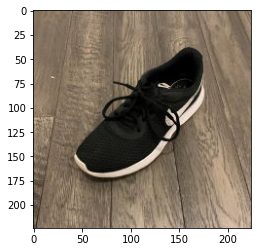

In [19]:
image_left=plt.imread('/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3/data/data/train/u001_1_left_w.jpg')
plt.imshow(image_left)

In [104]:
import glob
# Run for Shani
train_path = "/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3/data/data/train/*.jpg" # TODO - UPDATE ME!
train_files=[file.split("/")[-1] for file in  glob.glob(train_path)]

test_m_path = "/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3/data/data/test_m/*.jpg" # TODO - UPDATE ME!
test_m_files=[file.split("/")[-1] for file in  glob.glob(test_m_path)]

test_w_path = "/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3/data/data/test_w/*.jpg" # TODO - UPDATE ME!
test_w_files=[file.split("/")[-1] for file in  glob.glob(test_w_path)]


In [105]:
def files_to_df(files):
  df=pd.DataFrame(files)
  df=df.sort_values(by=0)
  df2=df.copy()
  df[0]= df[0].str.split("_", n = 1, expand = True)
  df.columns=['id']
  df['full_path']=df2
  df=df.reset_index(inplace=False).drop('index',axis=1)
  return df

df_train=files_to_df(train_files)
df_test_m=files_to_df(test_m_files)
df_test_w=files_to_df(test_w_files)

df_train.head()


,id,full_path
0,u001,u001_1_left_w.jpg
1,u001,u001_1_right_w.jpg
2,u001,u001_2_left_w.jpg
3,u001,u001_2_right_w.jpg
4,u001,u001_3_left_w.jpg


In [22]:
from sklearn.model_selection import train_test_split
def split_train_test(df_train):
  user=pd.DataFrame(list(set(df_train['id'])))
  train_users,val_users=train_test_split(user,test_size=0.2)

  train_users=list(train_users[0])
  val_users=list(val_users[0])

  train=df_train[df_train['id'].isin(train_users)]
  train=train.reset_index(inplace=False).drop('index',axis=1)

  val=df_train[df_train['id'].isin(val_users)]
  val=val.reset_index(inplace=False).drop('index',axis=1)
  return train,val

In [23]:
df_train , df_val= split_train_test(df_train)

In [24]:
def preapare_data(df,path_dir):
  data=list()
  users=list(set(df['id']))
  users.sort()
  for i,user in enumerate(users):
    # get datafram only for the specific user
    user_data=df[df['id'] == user]
    user_data=user_data.reset_index(inplace=False).drop('index',axis=1)
    user_array=list()

    # create numpy array for all user shoes
    j=0
    while j < 6:
      image_left=plt.imread(path_dir+ user_data.loc[j,"full_path"])
      image_left=image_left[:, :, :3]
      image_left =image_left/255 -0.5
      image_right=plt.imread(path_dir+ user_data.loc[j+1,"full_path"])
      image_right=image_right[:, :, :3]
      image_right=image_right/255 -0.5

      user_array.append([image_left,image_right])
      j+=2
    
    user_array=np.array(user_array)
    data.append(user_array)
  data=np.array(data)
  return data

In [106]:
train_data=preapare_data(df_train,train_path[:-5])
valid_data=preapare_data(df_val,train_path[:-5])
test_w_data=preapare_data(df_test_w,test_w_path[:-5])
test_m_data=preapare_data(df_test_m,test_m_path[:-5])


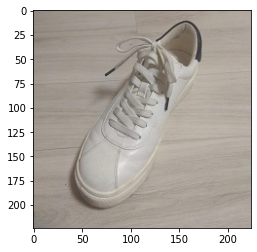

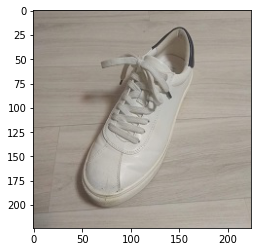

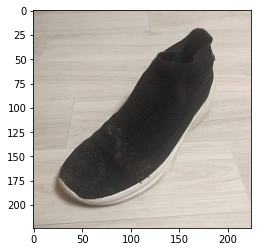

In [26]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]+0.5) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]+0.5) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]+0.5) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


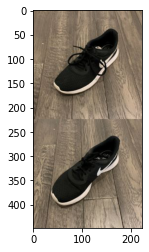

In [27]:
# Your code goes here
def generate_same_pair(data):
  same_pair = list()
  for user in range(0,len(data)):
    for pair in range(3):
      left_shoe = data[user,pair,0,:,:,:]
      right_shoe = data[user,pair,1,:,:,:]
      same_pair.append(np.concatenate([left_shoe,right_shoe]))

  same_pair = np.array(same_pair)
  return same_pair
 
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]+0.5) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


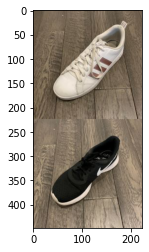

In [28]:
# Your code goes here
from random import sample

def generate_different_pair(data):
  all_possible_pairs=[(i,j) for i in range(3) for j in range(3) if i!=j]
  paired=list()
  for id in range(len(data)):
      pairs=sample(all_possible_pairs,3)
      for pair in pairs:
        left_shoe=data[id,pair[0],0,:,:]
        right_shoe=data[id,pair[1],1,:,:]
        new_data=np.concatenate((left_shoe, right_shoe), axis=0)
        paired.append(new_data)
  paired=np.array(paired)
  return paired

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]+0.5) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

We want our model to determine wether 2 shoes are from the same pair or different pair according to the shoes only .
When 2 images of shoes come from the same person they have the same (or very close) background, lightning and etc.

If we would take 2 shoes , each one from a different person, the backgroung should be different in each image and the model may learn that 2 shoes are from the same or diffenrent pair  accocrding to the background of the image. 

By keep each pair of images to be from the same person we force our model to focus on the shoe pixles and not other irrelevant factors.


### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Write your explanation here:**
The model we trained learn to classify according to the data it sees. If we created a data set where 99% of the images are of shoes that are not from the same pair , and 1% of the images are of shoes that are from the same pair the model will learn that it is best from him to just guess "not same pair".
We will get pretty good results in the training and even validation if we use again imbalanced data. But when applying the model on unseen data - it will just guess not the same pair regardless of the picture itself. 

It is obviously not a good model and we want to avoid it.


## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [29]:
class CNN(nn.Module):
    def __init__(self, n=4):
        super(CNN, self).__init__()
        kernel_size=5
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n, kernel_size=kernel_size, padding = int((kernel_size-1) / 2))
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=kernel_size, padding =int((kernel_size-1) / 2))
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=kernel_size, padding =int((kernel_size-1) / 2))
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n, kernel_size=kernel_size, padding =int((kernel_size-1) / 2))
        self.fc1 = nn.Linear(8*n*14*28, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x, verbose=False):
      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = self.conv2(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = self.conv3(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = self.conv4(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = nn.Flatten()(x)

      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      #x = F.log_softmax(x, dim=1)
      return x

### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [30]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()
        kernel_size=5
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=n, kernel_size=kernel_size, padding = int((kernel_size-1) / 2))
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=kernel_size, padding = int((kernel_size-1) / 2))
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=kernel_size, padding = int((kernel_size-1) / 2))
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n, kernel_size=kernel_size, padding = int((kernel_size-1) / 2))
        self.fc1 = nn.Linear(8*n*14*14, 100)
        self.fc2 = nn.Linear(100, 2)       
              
    def forward(self, x, verbose=False):
      left,right = torch.tensor_split(x,2,2)
      x = torch.cat((left,right),1)

      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = self.conv2(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = self.conv3(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = self.conv4(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = nn.Flatten()(x)

      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      #x = F.log_softmax(x, dim=1)
      return x

## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**
When using CNN ,the kernels of the next convolution look through all the channels of the feature vector.
If we combine along the channel dimension, it becomes easier for the network to compare pixel values at corresponding positions in both images. Since the objective is to predict similarity or dissimilarity, this is ideal for us.



## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Write your explanation here:**
We may wish to track the false positives and false negatives separately so could understand the model performence better, What it has learnt good and where the model is wrong and why .
For example if the model can recognize 100% of the pos example but only 40% of the neg examples we have avg accurazy of 70%. It may seem that most of the time we are good but actually the model succeed to learn only the positive example . 
In addition we get same avg accuract if we recofnize 60% positive and 80% negative examples.


In [31]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3)
        xs = xs.to(device)  # I added
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3)
        xs = xs.to(device)  # I added
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [32]:
def plot_single_learning_curve(epochs,losses,acc_train_pos,acc_train_neg,acc_val_pos,acc_val_neg):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    

    avg_acc_train=np.average([acc_train_pos,acc_train_neg],axis=0)
    avg_acc_val=np.average([acc_val_neg,acc_val_pos],axis=0)

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(epochs, avg_acc_train, label="Train avg acc ")
    plt.plot(epochs, avg_acc_val, label="Val avg acc")

    # plt.plot(epochs, acc_val_pos, label="Validation pos")
    # plt.plot(epochs, acc_val_neg, label="Validation neg")

    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def plot_losses(learning_curve_infos,title,rows,cols):
  fig, axes = plt.subplots(rows,cols, figsize=(20, 10))
  fig.suptitle("Loss per iteration",fontsize= 30)
  fig.subplots_adjust(top=0.9, wspace=0.3)

  for learning_curve_info,ax in zip(learning_curve_infos, axes.flatten()):
    epochs,losses,acc_train_pos,acc_train_neg,acc_val_pos,acc_val_neg = learning_curve_info
    ax.plot(epochs, losses, label="Train")
    ax.title.set_text(title)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")
    ax.legend(loc='best')


def plot_acc(learning_curve_infos,title,rows,cols):
  fig, axes = plt.subplots(rows,cols, figsize=(20, 10))
  fig.suptitle("Accuracy per iteration",fontsize= 30)
  fig.subplots_adjust(top=0.9, wspace=0.3)

  for learning_curve_info,ax in zip(learning_curve_infos, axes.flatten()):
    epochs,losses,acc_train_pos,acc_train_neg,acc_val_pos,acc_val_neg = learning_curve_info
    avg_acc_train=np.average([acc_train_pos,acc_train_neg],axis=0)
    avg_acc_val=np.average([acc_val_neg,acc_val_pos],axis=0)

    ax.title.set_text(title)
    # ax.plot(epochs, acc_train_neg, label="Train neg")
    ax.plot(epochs, avg_acc_train, label="Train avg")
    # ax.plot(epochs, acc_val_pos, label="Validation pos")
    ax.plot(epochs, avg_acc_val, label="Validation avg")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Accuracy")
    ax.legend(loc='best')

    
# change the method to implement multiple plotting
def plot_learning_curve(learning_curve_infos,title,rows=1,cols=1):
  if rows==1 and cols==1:
    plot_single_learning_curve(*learning_curve_infos[0])
    return
  plot_losses(learning_curve_infos,title,rows,cols)
  plot_acc(learning_curve_infos,title,rows,cols)

In [33]:
import pickle
from sklearn.utils import shuffle
def train(model,train_data=train_data, 
          validation_data=valid_data, 
          batch_size=100,
          learning_rate=0.001, 
          weight_decay=0,
          epochs=5, 
          max_iters=1000,
          checkpoint_path='/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3/data/ckpt-acc-{}.pk',
          best_avg_val_acc=0,
          best_avg_train_acc=0,
          to_save=False):
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay)

    

  data_pos = generate_same_pair(train_data)
  data_neg = generate_different_pair(train_data)
  labels_pos=torch.ones(int(batch_size / 2), dtype=torch.long)
  labels_neg=torch.zeros(int(batch_size / 2), dtype=torch.long)
  labels=torch.cat((labels_pos, labels_neg), 0)

  epochs_l,losses ,acc_train_pos,acc_train_neg,acc_val_pos,acc_val_neg = [], [] , [] , [] ,[],[]
  for epoch in range(epochs):
    #shuffling the positive and negative samples at the start of each epoch
    data_pos=shuffle(data_pos)
    data_neg=shuffle(data_neg)
    for i in range(0, len(data_pos)+len(data_neg),batch_size):
      if (i + batch_size) > data_pos.shape[0]:
        break
      
      xs_pos = torch.Tensor(data_pos[i:i+int(batch_size/2)]).transpose(1, 3)
      xs_neg = torch.Tensor(data_neg[i:i+int(batch_size/2)]).transpose(1, 3)
      xs = torch.cat((xs_pos, xs_neg), 0)  
      xs, labels = xs.to(device), labels.to(device)
      zs = model(xs) 
      loss = criterion(zs,labels)                 # compute the total loss 
      optimizer.zero_grad()                      # a clean up step for PyTorch
      loss.backward()                      # compute updates for each parameter
      optimizer.step()                        # make the updates for each parameter

    
    if (epoch+1) % 5 == 0:
        loss=2*float(loss)/batch_size
        pos_train_acc, neg_train_acc= get_accuracy(model, train_data , batch_size)
        optimizer.zero_grad() 
        pos_val_acc, neg_val_acc= get_accuracy(model, valid_data , batch_size)
        optimizer.zero_grad() 
        losses.append(loss)  # compute *average* loss
        acc_train_neg.append(neg_train_acc * 100)
        acc_train_pos.append(pos_train_acc * 100)
        acc_val_pos.append(pos_val_acc * 100)
        acc_val_neg.append(neg_val_acc * 100)
        epochs_l.append(epoch+1)
        avg_val_acc=100*(pos_val_acc + neg_val_acc)/2
        avg_train_acc=100*(pos_train_acc + neg_train_acc)/2
        # save the current training information
        print("Epoch %d.[Val avg Acc %.0f%%] [Val pos Acc %.0f%%] [Val neg Acc %.0f%%] [Train avg Acc %.0f%% Train pos Acc %.0f%%,Train neg Acc %.0f%%, Loss %f]" % (
              epoch+1, avg_val_acc,pos_val_acc * 100,neg_val_acc*100,avg_train_acc,pos_train_acc * 100,neg_train_acc*100, loss))
        if to_save:
          if avg_train_acc > best_avg_train_acc or (avg_train_acc == best_avg_train_acc and avg_val_acc > best_avg_val_acc):
            print("saving best model")
            best_avg_val_acc =avg_val_acc
            best_avg_train_acc=avg_train_acc
            torch.save(model.state_dict(), checkpoint_path.format(best_avg_val_acc))
            
            with open(checkpoint_path.format("plot for "+ str(best_avg_val_acc) ), 'wb') as f:
                  pickle.dump((epochs_l,losses,acc_train_pos,acc_train_neg,acc_val_pos,acc_val_neg ), f)
  
  return epochs_l,losses,acc_train_pos,acc_train_neg,acc_val_pos,acc_val_neg 



### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

In [ ]:
model = CNNChannel()
model.to(device)  
title=""
learning_curve_infos=train(model,train_data=train_data[:4,:,:,:,:,:], 
          validation_data=valid_data[:4,:,:,:,:,:], 
          batch_size=2,
          learning_rate=0.0005, 
          weight_decay=0,
          epochs=60)


Epoch 5.[Val avg Acc 53%] [Val pos Acc 35%] [Val neg Acc 71%] [Train pos Acc 33%,Train neg Acc 58%, Loss 0.707411]
Epoch 10.[Val avg Acc 49%] [Val pos Acc 23%] [Val neg Acc 74%] [Train pos Acc 17%,Train neg Acc 58%, Loss 0.722997]
Epoch 15.[Val avg Acc 49%] [Val pos Acc 32%] [Val neg Acc 65%] [Train pos Acc 50%,Train neg Acc 58%, Loss 0.647854]
Epoch 20.[Val avg Acc 54%] [Val pos Acc 43%] [Val neg Acc 64%] [Train pos Acc 58%,Train neg Acc 67%, Loss 0.388224]
Epoch 25.[Val avg Acc 67%] [Val pos Acc 91%] [Val neg Acc 42%] [Train pos Acc 100%,Train neg Acc 67%, Loss 0.034028]
Epoch 30.[Val avg Acc 71%] [Val pos Acc 97%] [Val neg Acc 45%] [Train pos Acc 100%,Train neg Acc 83%, Loss 0.034962]
Epoch 35.[Val avg Acc 67%] [Val pos Acc 80%] [Val neg Acc 55%] [Train pos Acc 83%,Train neg Acc 83%, Loss 0.270326]
Epoch 40.[Val avg Acc 72%] [Val pos Acc 90%] [Val neg Acc 54%] [Train pos Acc 100%,Train neg Acc 67%, Loss 0.023574]
Epoch 45.[Val avg Acc 70%] [Val pos Acc 80%] [Val neg Acc 59%] [Train 

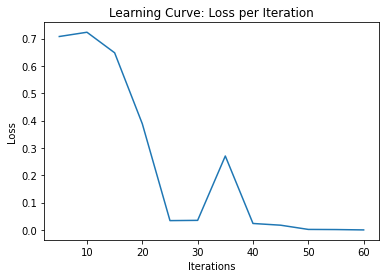

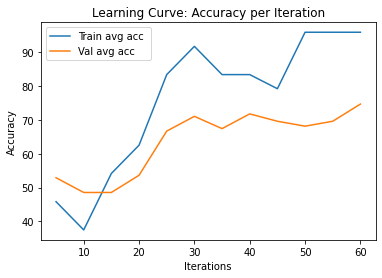

In [ ]:
plot_learning_curve([learning_curve_infos],title,rows=1,cols=1)

We have a little bit noisy learning but we can tell that the Accuracy is getting better as the epochs encrease and the loss is decreasing.

In [ ]:
model = CNN()
model.to(device)
learning_curve_infos = train(model,train_data=train_data[:4,:,:,:,:,:], 
          validation_data=valid_data[:4,:,:,:,:,:], 
          batch_size=3,
          learning_rate=0.0004, 
          weight_decay=0,
          epochs=60)

Epoch 5.[Val avg Acc 50%] [Val pos Acc 84%] [Val neg Acc 16%] [Train pos Acc 67%,Train neg Acc 42%, Loss 0.460551]
Epoch 10.[Val avg Acc 49%] [Val pos Acc 25%] [Val neg Acc 72%] [Train pos Acc 42%,Train neg Acc 58%, Loss 0.465156]
Epoch 15.[Val avg Acc 52%] [Val pos Acc 97%] [Val neg Acc 7%] [Train pos Acc 92%,Train neg Acc 17%, Loss 0.503611]
Epoch 20.[Val avg Acc 49%] [Val pos Acc 68%] [Val neg Acc 29%] [Train pos Acc 75%,Train neg Acc 25%, Loss 0.442462]
Epoch 25.[Val avg Acc 51%] [Val pos Acc 68%] [Val neg Acc 35%] [Train pos Acc 67%,Train neg Acc 17%, Loss 0.296783]
Epoch 30.[Val avg Acc 47%] [Val pos Acc 16%] [Val neg Acc 78%] [Train pos Acc 42%,Train neg Acc 58%, Loss 0.408579]
Epoch 35.[Val avg Acc 54%] [Val pos Acc 48%] [Val neg Acc 59%] [Train pos Acc 67%,Train neg Acc 42%, Loss 0.391104]
Epoch 40.[Val avg Acc 52%] [Val pos Acc 42%] [Val neg Acc 62%] [Train pos Acc 58%,Train neg Acc 75%, Loss 0.445531]
Epoch 45.[Val avg Acc 54%] [Val pos Acc 22%] [Val neg Acc 87%] [Train pos 

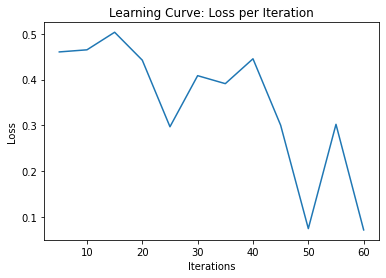

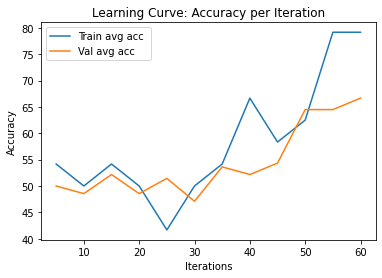

In [ ]:
plot_learning_curve([learning_curve_infos],title,rows=1,cols=1)

AS we expected the CNN channel got bettter results.

### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Write your explanation here:**
First we wanted to decide which criterions are best for us. 
Since we first want to get best accuracy on the training data we decided that the optimal model is the one with the highest average accuracy .
Since a lot of models has the same accuracy (for example 60% pos and 100% neg is with the same acc as 80% and 80%) we decided that if 2 models have the same avg train accuracy we will take the one with the greater validation avg accuracy.

In addition, as we did in assignment 2 , we saved our model in a checkpoint once in 5 epochs, if the model is better than the currently best result . So if the model is overfitted we take the early epoch and will get a better result than continue running all epochs. 

First we checked the results on the CNNC model .
We tarted with finding a resonable learning rate for each the network . 
First we started with big different between values : we chose lr in [0.00001,0.0001, 0.0005, 0.001,0.01].
We got pretty good result when using lr such as 0.0001 or 0.0005 . for lr = 0.00001 the training was to slow and for 0.01 and 0.001 we got only 100% and 0% for the positive and negative meaning the model just perfom same prediction no matter which image we got.
Next , we want to check a lr in range [0.0001,0.0005] to see if there is any difference and chose lr=0.0003.

Next, we want to check n . we checked n=[4,8,16] and got the best result with n=8 . 

Next, we tried different batch sizes at first we tried some value with big difference : [5,20,50] we did not find some big difference in model performence . We also tried closer values in range [5,8,12,20,30].
We chose batch size of 8 because we got the best result but not significally better\worst then other batch size.

we tried kernel size of 3 and 5 and got better results with 5 .

For CNN model - we did similiar steps and got best result for
lr = 0.0005, n = 4, kernel size = 5, betch size = 16

We explore all the hyper parameter simultaneously between our 2 computers and save checkpoint . Here we can see some of the hyper parameters checking 

In [20]:
# Finding decent learning rate  - after check lr coarse seach now we do fine search in the relevant learning rates.
n=4
bs=5
lrs=[0.0001,0.0003,0.0005]
n=8
learning_curve_infos=[]
models={}
for lr in lrs:
  # for n in ns:
    print("n=",n,"bs=",bs,"lr",lr)
    model = CNNChannel(n = n)
    model.to(device)
    models[(n,lr,bs)]=model
    learning_curve_infos.append(train(model,train_data=train_data, 
              validation_data=valid_data, 
              batch_size=bs,
              learning_rate=lr, 
              weight_decay=0,
              epochs=100,
              to_save=True))


n= 8 bs= 5 lr 0.0001
Epoch 5.[Val avg Acc 49%] [Val pos Acc 86%] [Val neg Acc 12%] [Train avg Acc 50% Train pos Acc 92%,Train neg Acc 7%, Loss 0.280784]
saving best model
Epoch 10.[Val avg Acc 46%] [Val pos Acc 39%] [Val neg Acc 52%] [Train avg Acc 50% Train pos Acc 27%,Train neg Acc 73%, Loss 0.280585]
saving best model
Epoch 15.[Val avg Acc 55%] [Val pos Acc 54%] [Val neg Acc 57%] [Train avg Acc 53% Train pos Acc 57%,Train neg Acc 48%, Loss 0.277502]
saving best model
Epoch 20.[Val avg Acc 51%] [Val pos Acc 62%] [Val neg Acc 41%] [Train avg Acc 50% Train pos Acc 47%,Train neg Acc 54%, Loss 0.276439]
Epoch 25.[Val avg Acc 52%] [Val pos Acc 55%] [Val neg Acc 49%] [Train avg Acc 52% Train pos Acc 49%,Train neg Acc 54%, Loss 0.258831]
Epoch 30.[Val avg Acc 79%] [Val pos Acc 94%] [Val neg Acc 64%] [Train avg Acc 75% Train pos Acc 82%,Train neg Acc 67%, Loss 0.193296]
saving best model
Epoch 35.[Val avg Acc 76%] [Val pos Acc 90%] [Val neg Acc 62%] [Train avg Acc 78% Train pos Acc 91%,Train

In [ ]:
plot_learning_curve(learning_curve_infos,title,rows=1,cols=3)

In [23]:
# trying differeny batch sizes - fine search
n=4
lr=0.0001
n=8
bss=[5,8,12,20,30]
learning_curve_infos={}
models_bs={}
for bs in bss:
    print("n=",n,"bs=",bs,"lr",lr)
    model = CNNChannel(n = n)
    model.to(device)
    models[(n,lr,bs)]=model
    learning_curve_infos[(n,lr,bs)]=train(model,train_data=train_data, 
              validation_data=valid_data, 
              batch_size=bs,
              learning_rate=lr, 
              weight_decay=0,
              epochs=100,
              to_save=True)


n= 8 bs= 5 lr 0.0005
Epoch 5.[Val avg Acc 51%] [Val pos Acc 33%] [Val neg Acc 68%] [Train avg Acc 51% Train pos Acc 39%,Train neg Acc 63%, Loss 0.277233]
saving best model
Epoch 10.[Val avg Acc 49%] [Val pos Acc 7%] [Val neg Acc 91%] [Train avg Acc 49% Train pos Acc 19%,Train neg Acc 79%, Loss 0.276398]
Epoch 15.[Val avg Acc 55%] [Val pos Acc 30%] [Val neg Acc 80%] [Train avg Acc 52% Train pos Acc 38%,Train neg Acc 66%, Loss 0.276601]
saving best model
Epoch 20.[Val avg Acc 57%] [Val pos Acc 30%] [Val neg Acc 83%] [Train avg Acc 54% Train pos Acc 46%,Train neg Acc 62%, Loss 0.272715]
saving best model
Epoch 25.[Val avg Acc 52%] [Val pos Acc 70%] [Val neg Acc 35%] [Train avg Acc 60% Train pos Acc 81%,Train neg Acc 38%, Loss 0.262309]
saving best model
Epoch 30.[Val avg Acc 65%] [Val pos Acc 71%] [Val neg Acc 59%] [Train avg Acc 65% Train pos Acc 79%,Train neg Acc 51%, Loss 0.504331]
saving best model
Epoch 35.[Val avg Acc 64%] [Val pos Acc 71%] [Val neg Acc 58%] [Train avg Acc 73% Train

### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

In [40]:
best_model_cnnc_plot="ckpt-acc-plot for 88.40579710144927.pk"
# best_model_cnnc=torch.load()
with open('/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3/data/'+best_model_cnnc_plot, 'rb') as model_data:
    info = pickle.load(model_data)


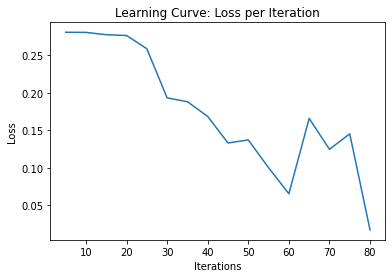

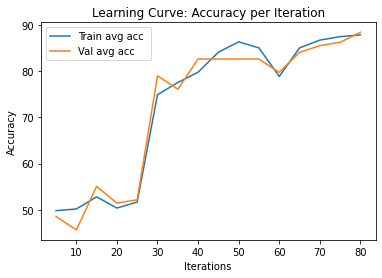

In [41]:
plot_learning_curve([info],"Best model CNNC",rows=1,cols=1)

In [126]:
model_cnnc = CNNChannel(n=8)
model_cnnc.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3/data/ckpt-acc-88.40579710144927.pk'),)


<All keys matched successfully>

In [118]:
best_model_cnn_plot="ckpt-acc-plot for 71.01449275362319.pk"
# best_model_cnnc=torch.load()
with open('/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3/data/cnn/'+best_model_cnn_plot, 'rb') as model_data:
    info = pickle.load(model_data)


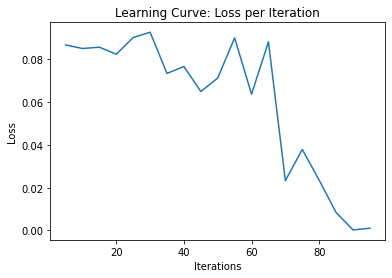

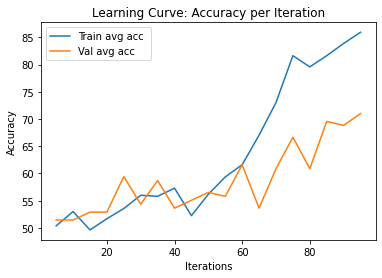

In [119]:
plot_learning_curve([info],"Best model CNN",rows=1,cols=1)

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [59]:
test_acc_pos, test_acc_neg = get_accuracy(model_cnnc, valid_data)
print("Test set: [Acc (avg %.0f%%), (positives %.0f%%), (negatives: %.0f%%)]" % (
      ((test_acc_pos+test_acc_neg)/2) * 100, test_acc_pos * 100, test_acc_neg * 100))

Test set: [Acc (avg 90%), (positives 99%), (negatives: 81%)]


In [127]:
test_acc_pos, test_acc_neg = get_accuracy(model_cnnc, test_m_data)
print("Test set: [Acc (avg %.0f%%), (positives %.0f%%), (negatives: %.0f%%)]" % (
      ((test_acc_pos+test_acc_neg)/2) * 100, test_acc_pos * 100, test_acc_neg * 100))

Test set: [Acc (avg 72%), (positives 90%), (negatives: 53%)]


In [128]:
test_acc_pos, test_acc_neg = get_accuracy(model_cnnc, test_w_data)
print("Test set: [Acc (avg %.0f%%), (positives %.0f%%), (negatives: %.0f%%)]" % (
      ((test_acc_pos+test_acc_neg)/2) * 100, test_acc_pos * 100, test_acc_neg * 100))

Test set: [Acc (avg 75%), (positives 93%), (negatives: 57%)]


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.



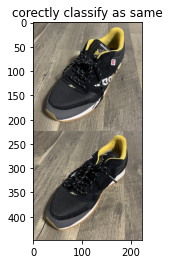

In [90]:
def plot_correct_pos(model,data):
  data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
  data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]
  plot_true_pos,plot_false_pos,plot_true_neg,plot_flase_neg=True,True,True,True
  for i in range(0, len(data_pos), 1):
    xs = torch.Tensor(data_pos[i:i+1]).transpose(1, 3)
    xs = xs.to(device)  # I added
    zs = model(xs)
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()
    if pred==1:
      plt.figure()
      plt.title("corectly classify as same")
      plt.imshow(data_pos[i]+0.5)
      return

plot_correct_pos(model_cnnc,test_m_data)


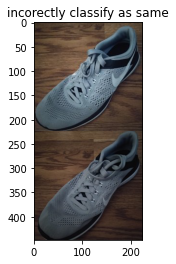

In [112]:
def plot_incorrect_pos(model,data):
  data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
  data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]
  plot_true_pos,plot_false_pos,plot_true_neg,plot_flase_neg=True,True,True,True
  for i in range(0, len(data_pos), 1):
    xs = torch.Tensor(data_pos[i:i+1]).transpose(1, 3)
    xs = xs.to(device)  # I added
    zs = model(xs)
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()
    if pred==0:
      plt.figure()
      plt.title("incorectly classify as not same")
      plt.imshow(data_pos[i]+0.5)
      return

plot_incorrect_pos(model_cnnc,test_m_data)



### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

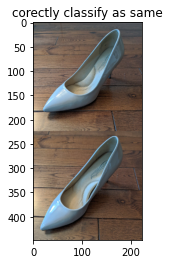

In [114]:
def plot_correct_pos(model,data):
  data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
  data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]
  plot_true_pos,plot_false_pos,plot_true_neg,plot_flase_neg=True,True,True,True
  for i in range(0, len(data_pos), 1):
    xs = torch.Tensor(data_pos[i:i+1]).transpose(1, 3)
    xs = xs.to(device)  # I added
    zs = model(xs)
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()
    if pred==1:
      plt.figure()
      plt.title("corectly classify as same")
      plt.imshow(data_pos[i]+0.5)
      return

plot_correct_pos(model_cnnc,test_w_data)


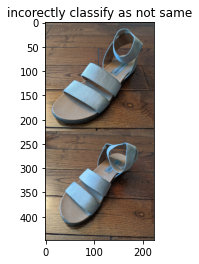

In [113]:
def plot_incorrect_pos(model,data):
  data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
  data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]
  plot_true_pos,plot_false_pos,plot_true_neg,plot_flase_neg=True,True,True,True
  for i in range(0, len(data_pos), 1):
    xs = torch.Tensor(data_pos[i:i+1]).transpose(1, 3)
    xs = xs.to(device)  # I added
    zs = model(xs)
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()
    if pred==0:
      plt.figure()
      plt.title("incorectly classify as not same")
      plt.imshow(data_pos[i]+0.5)
      return

plot_incorrect_pos(model_cnnc,test_w_data)
